In [1]:
!pip install socceraction -q

In [13]:
!pip install tables -q

In [18]:
!pip install xgboost -q
!pip install matplotlib -q

In [1]:
from socceraction.data.wyscout import WyscoutLoader
from socceraction.spadl.wyscout import convert_to_actions
import socceraction.spadl as spadl
import socceraction.atomic.spadl as atomicspadl
import socceraction.vaep.features as features
import socceraction.vaep.labels as labels

In [2]:
import os
#import wyscoutapi

def load_environment_vars():
    # Get the current working directory
    cwd = os.getcwd()

    # Append the .env file name
    env_path = os.path.join(cwd, '../.env')

    # Open the .env file
    with open(env_path) as f:
        # Read the lines
        lines = f.readlines()

    # Parse the key-value pairs
    for line in lines:
        # Ignore comments and empty lines
        if line.startswith('#') or not line.strip():
            continue
        # Split the line into key and value
        key, value = line.strip().split('=', 1)
        # Set the environment variable
        os.environ[key] = value

    return os.environ['WYSCOUT_API_USER'], os.environ['WYSCOUT_API_PASSWORD']

#def create_wyscout_client(username, password):
#    return wyscoutapi.WyscoutAPI(username=username, password=password)

In [4]:
# set authentication credentials as environment variables
username, password = load_environment_vars()

# or provide authentication credentials as a dictionary
api = WyscoutLoader(getter="remote", creds={"user":username, "passwd": password})

In [5]:
import pandas as pd

In [6]:
df = pd.read_csv('../data/raw/teams_and_seasons.csv')
league_season_dict = {league_id: season for league_id, season in zip(df['league_id'], df['season_p1'])}

In [ ]:
dfs_matches = []

for competition, season in league_season_dict.items():
    df_matches = api.games(competition_id=competition, season_id=season)
    dfs_matches.append(df_matches)

df_matches = pd.concat(dfs_matches)

In [8]:
last_premier_games = api.games(364,188989)

/home/pastor/anaconda3/envs/socceraction/lib/python3.10/site-packages/socceraction/data/wyscout/loader.py:560: UserWarning: Resource not found: matches/5465087/events?fetch=teams,players,match,coaches,referees,formations,substitutions
  warnings.warn(f"Resource not found: {gamedetails_url}")
/home/pastor/anaconda3/envs/socceraction/lib/python3.10/site-packages/socceraction/data/wyscout/loader.py:560: UserWarning: Resource not found: matches/5465072/events?fetch=teams,players,match,coaches,referees,formations,substitutions
  warnings.warn(f"Resource not found: {gamedetails_url}")


In [6]:
last_premier_games

,game_id,competition_id,season_id,game_date,game_day,home_team_id,away_team_id
0,5465093,364,188989,2023-12-28 20:15:00,19,1609,1633
1,5465095,364,188989,2023-12-28 19:30:00,19,1651,1624
2,5465098,364,188989,2023-12-27 20:15:00,19,1623,1625
3,5465094,364,188989,2023-12-27 19:30:00,19,1669,1629
4,5465097,364,188989,2023-12-27 19:30:00,19,1610,1628
...,...,...,...,...,...,...,...
183,5464915,364,188989,2023-08-12 14:00:00,1,1651,1660
184,5464916,364,188989,2023-08-12 14:00:00,1,1623,1616
185,5464917,364,188989,2023-08-12 14:00:00,1,1636,1628
186,5464913,364,188989,2023-08-12 12:00:00,1,1609,1642


In [7]:
last_30_games = last_premier_games.head(5)

In [8]:
last_30_games

,game_id,competition_id,season_id,game_date,game_day,home_team_id,away_team_id
0,5465098,364,188989,2023-12-27 20:15:00,19,1623,1625
1,5465094,364,188989,2023-12-27 19:30:00,19,1669,1629
2,5465097,364,188989,2023-12-27 19:30:00,19,1610,1628
3,5465099,364,188989,2023-12-26 20:00:00,19,1611,1614
4,5465096,364,188989,2023-12-26 17:30:00,19,1646,1612


# Pre-processing and dataset storage: actions, features, labels

In [8]:
functions_features = [
    features.actiontype_onehot,
    features.bodypart_onehot,
    features.result_onehot,
    features.goalscore,
    features.startlocation,
    features.endlocation,
    features.movement,
    features.space_delta,
    features.startpolar,
    features.endpolar,
    features.team,
    features.time_delta
]

functions_labels = [
    labels.scores,
    labels.concedes
]

for game_id, home_team_id in zip(last_30_games['game_id'].values, last_30_games['home_team_id'].values):
    last_game_event = api.events(game_id)
    spadl_df = convert_to_actions(last_game_event, home_team_id)
    team_name = api.teams(game_id=game_id)
    team_name.to_hdf('teams.h5', key=f'game_{game_id}')

    player_name = api.players(game_id=game_id)
    player_name.to_hdf('players.h5', key=f'game_{game_id}')

    df_actions = (
    spadl
    .add_names(spadl_df)  # add actiontype and result names
    .merge(team_name)  # add team names
    .merge(player_name)  # add player names
    )
    df_actions.to_hdf('actions.h5', key=f'game_{game_id}')

    #df_actions_atomic = atomicspadl.convert_to_atomic(df_actions)
    df_actions_atomic = (
        atomicspadl
        .add_names(df_actions)  # add actiontype and result names
        .merge(team_name)  # add team names
        .merge(player_name)  # add player names
        )

    df_actions_atomic.to_hdf('atomic_actions.h5', key=f'game_{game_id}')
    
    gamestates = features.gamestates(df_actions,3)
    gamestates = features.play_left_to_right(gamestates, home_team_id)

    df_features = pd.concat([fn(gamestates) for fn in functions_features], axis=1)
    df_features.to_hdf('features.h5', key=f'game_{game_id}')
    # 3. compute labels
    df_labels = pd.concat([fn(df_actions) for fn in functions_labels], axis=1)
    df_labels.to_hdf('labels.h5', key=f'game_{game_id}')

/tmp/ipykernel_4037538/2053725276.py:36: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block4_values] [items->Index(['original_event_id', 'type_name', 'result_name', 'bodypart_name',
       'team_name_short', 'team_name', 'nickname', 'firstname', 'lastname',
       'player_name'],
      dtype='object')]

  df_actions.to_hdf('actions.h5', key=f'game_{game_id}')
/tmp/ipykernel_4037538/2053725276.py:46: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block4_values] [items->Index(['original_event_id', 'result_name', 'team_name_short', 'team_name',
       'nickname', 'firstname', 'lastname', 'player_name', 'type_name',
       'bodypart_name'],
      dtype='object')]

  df_actions_atomic.to_hdf('atomic_actions.h5', key=f'game_{game_id}')
/home/pastor/anaconda3/envs/socc

In [9]:
columns_features = features.feature_column_names(functions_features, nb_prev_actions=3)
columns_labels = [
    'scores',
    'concedes'
]

In [10]:
dfs_features = []
dfs_labels = []
for game_id, home_team_id in zip(last_30_games['game_id'].values, last_30_games['home_team_id'].values):
    df_features = pd.read_hdf('features.h5', key=f'game_{game_id}')
    dfs_features.append(df_features[columns_features])

    df_labels = pd.read_hdf('labels.h5', key=f'game_{game_id}')
    dfs_labels.append(df_labels[columns_labels])
    
df_labels2 = pd.concat(dfs_labels).reset_index(drop=True)
df_features2 = pd.concat(dfs_features).reset_index(drop=True)

In [11]:
df_labels2

,scores,concedes
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False
...,...,...
7000,False,False
7001,False,False
7002,False,False
7003,False,False


# Make predictions XGBoost model

In [19]:
from xgboost import XGBClassifier

In [20]:
models = {}
for column_labels in columns_labels:
    model = XGBClassifier(
        eval_metric='logloss',
        use_label_encoder=False
    )
    model.fit(df_features, df_labels[column_labels])
    models[column_labels] = model

In [21]:
dfs_predictions = {}
for column_labels in columns_labels:
    model = models[column_labels]
    probabilities = model.predict_proba(df_features)
    predictions = probabilities[:, 1]
    dfs_predictions[column_labels] = pd.Series(predictions)
df_predictions = pd.concat(dfs_predictions, axis=1)

In [22]:
dfs_game_ids = []
for game_id, home_team_id in zip(last_30_games['game_id'].values, last_30_games['home_team_id'].values):
    df_actions = pd.read_hdf('actions.h5', key=f'game_{game_id}')
    dfs_game_ids.append(df_actions['game_id'])
df_game_ids = pd.concat(dfs_game_ids, axis=0).astype('int').reset_index(drop=True)

In [23]:
df_predictions = pd.concat([df_predictions, df_game_ids], axis=1)
df_predictions_per_game = df_predictions.groupby('game_id')

In [24]:
for game_id, df_predictions in df_predictions_per_game:
    df_predictions = df_predictions.reset_index(drop=True)
    df_predictions[columns_labels].to_hdf('predictions.h5', key=f'game_{game_id}')

# Value on the ball actions

In [25]:
import socceraction.vaep.formula as vaepformula
# 6. compute VAEP value
values = vaepformula.value(df_actions, df_predictions["scores"], df_predictions["concedes"])

In [26]:
dfs_values = []
for game_id, home_team_id in zip(last_30_games['game_id'].values, last_30_games['home_team_id'].values):
    df_actions = pd.read_hdf('actions.h5', key=f'game_{game_id}')
    df_players = api.players(game_id)
    df_teams = api.teams(game_id)
    df_actions = (df_actions
        .merge(df_players, how='left')
        .merge(df_teams, how='left')
        .reset_index(drop=True)
    )
    
    df_predictions = pd.read_hdf('predictions.h5', key=f'game_{game_id}')
    df_values =  vaepformula.value(df_actions, df_predictions['scores'], df_predictions['concedes'])
    
    df_all = pd.concat([df_actions, df_predictions, df_values], axis=1)
    dfs_values.append(df_all)

In [27]:
df_values = (pd.concat(dfs_values)
    .sort_values(['game_id', 'period_id', 'time_seconds'])
    .reset_index(drop=True)
)

In [28]:
df_ranking = (df_values[['player_id', 'team_name', 'nickname', 'vaep_value']]
    .groupby(['player_id', 'team_name', 'nickname'])
    .agg(vaep_count=('vaep_value', 'count'), vaep_sum=('vaep_value', 'sum'))
    .sort_values('vaep_sum', ascending=False)
    .reset_index()
)

In [29]:
df_values.drop_duplicates(subset=['game_id', 'player_id', 'minutes_played'], keep='first', inplace=True)
df_minutes_played = df_values.groupby(['game_id', 'player_id'])['minutes_played'].sum().reset_index()

In [32]:
df_ranking_p90 = df_ranking.merge(df_minutes_played)
df_ranking_p90 = df_ranking_p90[df_ranking_p90['minutes_played'] > 60]
df_ranking_p90['vaep_rating'] = df_ranking_p90['vaep_sum'] * 90 / df_ranking_p90['minutes_played']
df_ranking_p90 = df_ranking_p90.sort_values('vaep_rating', ascending=False)

In [33]:
df_ranking_p90

,player_id,team_name,nickname,vaep_count,vaep_sum,game_id,minutes_played,vaep_rating
1,657854,Burnley FC,W. Odobert,32,6.634634,5465084,86,6.943221
0,120353,Liverpool FC,Mohamed Salah,37,6.705200,5465085,100,6.034680
2,367922,Burnley FC,S. Berge,46,5.680052,5465084,101,5.061433
3,520291,Arsenal FC,B. Saka,62,4.722442,5465085,100,4.250198
4,415917,Arsenal FC,Gabriel Magalhaes,48,1.874123,5465085,100,1.686711
5,302292,Arsenal FC,M. Ødegaard,82,0.092183,5465085,100,0.082965
8,531397,Burnley FC,L. Foster,32,0.054368,5465084,70,0.069902
6,565847,Burnley FC,Vitinho,54,0.069760,5465084,101,0.062162
7,340386,Arsenal FC,Gabriel Jesus,27,0.054958,5465085,83,0.059593
9,379209,Arsenal FC,D. Rice,88,0.049753,5465085,100,0.044778


# Generating features

In [38]:
!pip install matplotsoccer -q

In [41]:
!pip install matplotlib -q

In [31]:
import matplotsoccer

In [12]:
last_30_games

,game_id,competition_id,season_id,game_date,game_day,home_team_id,away_team_id
0,5465093,364,188989,2023-12-28 20:15:00,19,1609,1633
1,5465095,364,188989,2023-12-28 19:30:00,19,1651,1624
2,5465098,364,188989,2023-12-27 20:15:00,19,1623,1625
3,5465094,364,188989,2023-12-27 19:30:00,19,1669,1629
4,5465097,364,188989,2023-12-27 19:30:00,19,1610,1628


In [11]:
import pandas as pd

In [13]:
df_teams_concat = pd.DataFrame()
df_players_concat = pd.DataFrame()
for game in last_30_games['game_id']:
    df_teams = pd.read_hdf('teams.h5', key=f'game_{game}')
    # concat df teams
    df_teams_concat = pd.concat([df_teams_concat, df_teams])
    df_players = pd.read_hdf('players.h5', key=f'game_{game}')
    # concat df players
    df_players_concat = pd.concat([df_players_concat, df_players])
    

In [14]:
team_name_mapping = df_teams_concat.set_index('team_id')['team_name'].to_dict()
last_30_games['home_team_name'] = last_30_games['home_team_id'].map(team_name_mapping)
last_30_games['away_team_name'] = last_30_games['away_team_id'].map(team_name_mapping)

/tmp/ipykernel_4037538/2662188581.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_30_games['home_team_name'] = last_30_games['home_team_id'].map(team_name_mapping)
/tmp/ipykernel_4037538/2662188581.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  last_30_games['away_team_name'] = last_30_games['away_team_id'].map(team_name_mapping)


In [15]:
last_30_games

,game_id,competition_id,season_id,game_date,game_day,home_team_id,away_team_id,home_team_name,away_team_name
0,5465093,364,188989,2023-12-28 20:15:00,19,1609,1633,Arsenal FC,West Ham United FC
1,5465095,364,188989,2023-12-28 19:30:00,19,1651,1624,Brighton & Hove Albion FC,Tottenham Hotspur FC
2,5465098,364,188989,2023-12-27 20:15:00,19,1623,1625,Everton FC,Manchester City FC
3,5465094,364,188989,2023-12-27 19:30:00,19,1669,1629,Brentford FC,Wolverhampton Wanderers FC
4,5465097,364,188989,2023-12-27 19:30:00,19,1610,1628,Chelsea FC,Crystal Palace FC


In [17]:
game_id = last_30_games['game_id'].values[0]

In [18]:
df_actions_atomic = pd.read_hdf('atomic_actions.h5', key=f'game_{game_id}')

In [19]:
df_actions = pd.read_hdf('actions.h5', key=f'game_{game_id}')

In [20]:
df_actions.columns

Index(['game_id', 'period_id', 'time_seconds', 'team_id', 'player_id',
       'start_x', 'start_y', 'end_x', 'end_y', 'original_event_id',
       'bodypart_id', 'type_id', 'result_id', 'action_id', 'type_name',
       'result_name', 'bodypart_name', 'team_name_short', 'team_name',
       'nickname', 'firstname', 'lastname', 'birth_date', 'player_name',
       'jersey_number', 'minutes_played', 'is_starter'],
      dtype='object')

In [21]:
df_actions_atomic.columns

Index(['game_id', 'period_id', 'time_seconds', 'team_id', 'player_id',
       'start_x', 'start_y', 'end_x', 'end_y', 'original_event_id',
       'bodypart_id', 'type_id', 'result_id', 'action_id', 'result_name',
       'team_name_short', 'team_name', 'nickname', 'firstname', 'lastname',
       'birth_date', 'player_name', 'jersey_number', 'minutes_played',
       'is_starter', 'type_name', 'bodypart_name'],
      dtype='object')

In [22]:
def nice_time(row):
    minute = int((row['period_id']>=2) * 45 + (row['period_id']>=3) * 15 + 
                 (row['period_id']==4) * 15 + row['time_seconds'] // 60)
    second = int(row['time_seconds'] % 60)
    return f'{minute}m{second}s'

In [23]:
def action_name(row):
    return f"{row['action_id']}: {row['nice_time']} - {row['nickname']} {row['type_name']}"

In [24]:
df_actions['nice_time'] = df_actions.apply(nice_time,axis=1)
df_actions['action_name'] = df_actions.apply(action_name, axis=1)

In [25]:
df_actions_atomic['nice_time'] = df_actions_atomic.apply(nice_time,axis=1)
df_actions_atomic['action_name'] = df_actions_atomic.apply(action_name, axis=1)

In [26]:
def plot_actions(df_actions_to_plot):
    matplotsoccer.actions(
        location=df_actions_to_plot[['start_x', 'start_y', 'end_x', 'end_y']],
        action_type=df_actions_to_plot['type_name'],
        team=df_actions_to_plot['team_name'],
        result=df_actions_to_plot['result_id'] == 'success',
        label=df_actions_to_plot[['nice_time', 'type_name', 'nickname', 'team_name_short', 'jersey_number']],
        labeltitle=['time', 'actiontype', 'player', 'team', 'number'],
        zoom=False,
        figsize=8)

In [27]:
def plot_actions_from_action_name(df_actions, action_name):
    action_id = int(action_name.split(':')[0])
    df_actions_to_plot = df_actions[action_id-3: action_id+3]
    plot_actions(df_actions_to_plot)

In [28]:
# sort values by period id and time seconds
df_actions_atomic = df_actions_atomic.sort_values(['period_id', 'time_seconds']).reset_index()

In [29]:
# sort values by period id and time seconds
df_actions = df_actions.sort_values(['period_id', 'time_seconds']).reset_index()

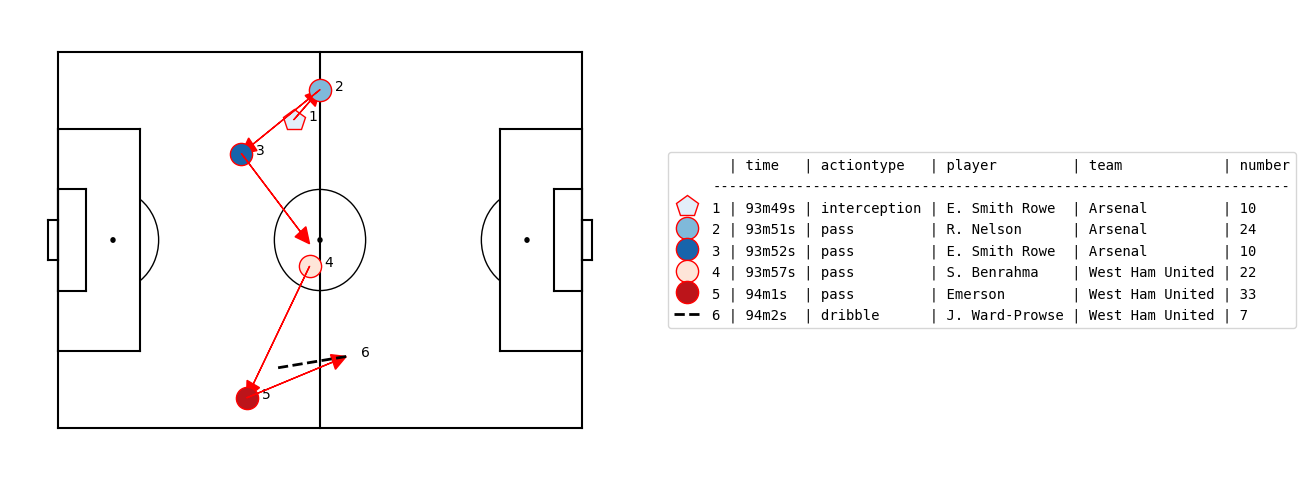

In [33]:
plot_actions_from_action_name(df_actions_atomic, df_actions_atomic['action_name'][1400])

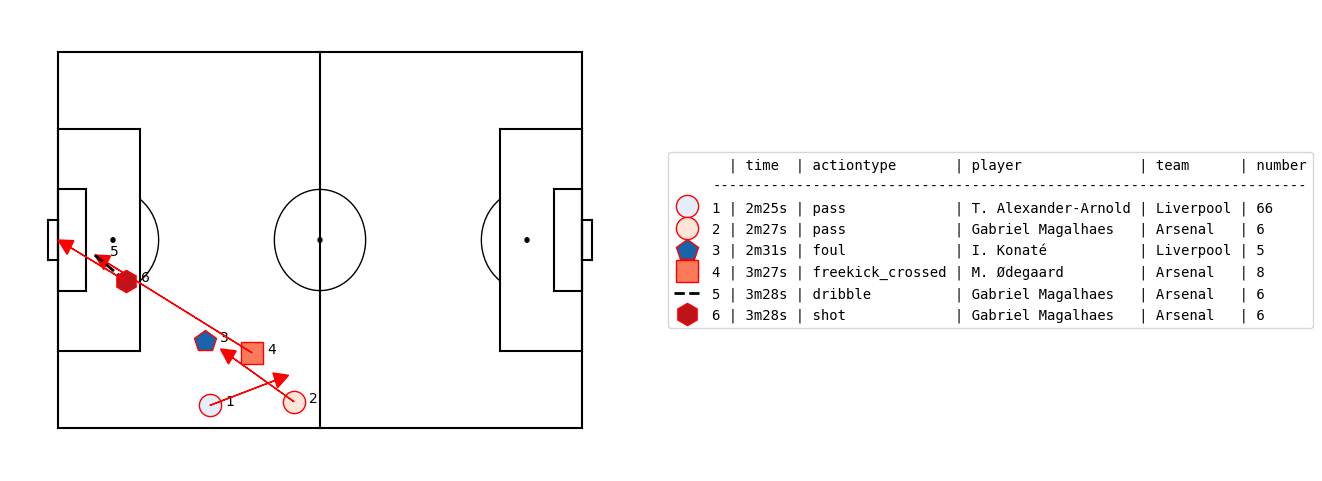

In [277]:
plot_actions_from_action_name(df_actions_atomic, df_actions_atomic['action_name'][39])

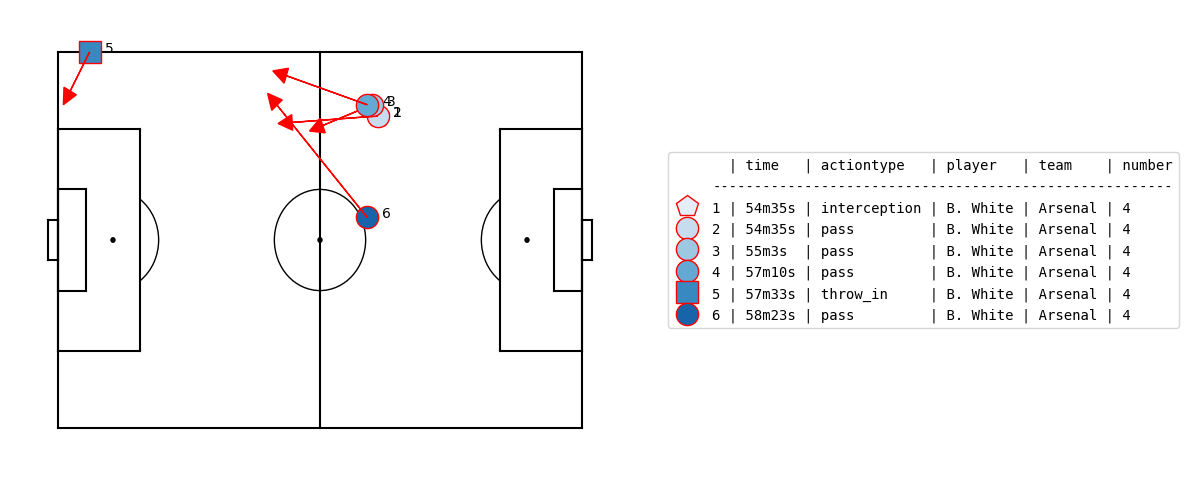

In [244]:
plot_actions_from_action_name(df_actions, df_actions['action_name'][15])

In [23]:
df_actions['action_name']

0             0: 0m2s - Gabriel Jesus pass
1           12: 0m30s - Gabriel Jesus shot
2            15: 1m8s - Gabriel Jesus shot
3           22: 1m31s - Gabriel Jesus pass
4         109: 11m15s - Gabriel Jesus pass
                       ...                
1230    1158: 86m54s - R. Gravenberch foul
1231    1167: 88m53s - R. Gravenberch pass
1232    1221: 94m13s - R. Gravenberch pass
1233    1225: 94m19s - R. Gravenberch pass
1234    1240: 94m56s - R. Gravenberch pass
Name: action_name, Length: 1235, dtype: object

## Representing location

In [174]:
PITCH_LENGTH = 105
PITCH_WIDTH = 68
action_id = 145

In [172]:
df_actions[action_id:action_id+1][['start_x', 'start_y', 'end_x', 'end_y']]

,start_x,start_y,end_x,end_y
145,96.6,46.24,86.1,49.64


In [175]:
for side in ['start', 'end']:
    # Normalize the X location
    key_x = f'{side}_x'
    df_actions[f'{key_x}_norm'] = df_actions[key_x] / PITCH_LENGTH

    # Normalize the Y location
    key_y = f'{side}_y'
    df_actions[f'{key_y}_norm'] = df_actions[key_y] / PITCH_WIDTH

In [176]:
df_actions[action_id:action_id+1][['start_x_norm', 'start_y_norm', 'end_x_norm', 'end_y_norm']]

,start_x_norm,start_y_norm,end_x_norm,end_y_norm
145,0.92,0.68,0.82,0.73


In [177]:
GOAL_X = PITCH_LENGTH
GOAL_Y = PITCH_WIDTH / 2

In [179]:
import numpy as np

In [180]:
for side in ['start', 'end']:
    diff_x = GOAL_X - df_actions[f'{side}_x']
    diff_y = abs(GOAL_Y - df_actions[f'{side}_y'])
    df_actions[f'{side}_distance_to_goal'] = np.sqrt(diff_x ** 2 + diff_y ** 2)
    df_actions[f'{side}_angle_to_goal'] = np.divide(diff_x, diff_y, 
                                                    out=np.zeros_like(diff_x), 
                                                    where=(diff_y != 0))

In [181]:
df_actions[action_id:action_id+1][['start_distance_to_goal', 'start_angle_to_goal', 'end_distance_to_goal', 'end_angle_to_goal']]


,start_distance_to_goal,start_angle_to_goal,end_distance_to_goal,end_angle_to_goal
145,14.84512,0.686275,24.532012,1.20844


In [182]:
for side in ['start', 'end']:
    df_actions[f'{side}_is_penalty_box'] = ((df_actions[f'{side}_x'] > (PITCH_LENGTH-16.5)) & 
                                            (df_actions[f'{side}_y'] > (13.85)) & 
                                            (df_actions[f'{side}_y'] > (PITCH_WIDTH-13.85)))

In [183]:
df_actions[action_id:action_id+1][['start_is_penalty_box', 'end_is_penalty_box']]

,start_is_penalty_box,end_is_penalty_box
145,False,False


## Representing body part, action type and result

In [184]:
def add_action_type_dummies(df_actions):
    return df_actions.merge(pd.get_dummies(df_actions['type_name']), how='left',
                             left_index=True, right_index=True)

In [185]:
df_actions = add_action_type_dummies(df_actions)

In [186]:
df_actions[action_id:action_id+1]

,index,game_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,...,freekick_crossed,freekick_short,goalkick,interception,keeper_save,pass,shot,tackle,take_on,throw_in
145,234,5465085,1,886.95,1609,520291,96.6,46.24,86.1,49.64,...,0,0,0,0,0,0,0,0,0,0


In [187]:
df_actions['bodypart_name'].unique()

array(['foot', 'head', 'head/other', 'other'], dtype=object)

In [188]:
df_actions['result_name'].unique()

array(['success', 'fail', 'offside'], dtype=object)

In [189]:
df_actions[action_id:action_id+1][['bodypart_name', 'result_name']]

,bodypart_name,result_name
145,foot,success


## Determine distance covered in x, y and total time played

In [190]:
def add_distance_features(df_actions):
    df_actions['diff_x'] = df_actions['end_x'] - df_actions['start_x']
    df_actions['diff_y'] = df_actions['end_y'] - df_actions['start_y']
    df_actions['distance_covered'] = np.sqrt((df_actions['end_x'] - df_actions['start_x']) ** 2 +
                                             (df_actions['end_y'] - df_actions['start_y']) ** 2)

In [191]:
def add_time_played(df_actions):
    df_actions['time_played'] = (df_actions['time_seconds'] + 
                             (df_actions['period_id'] >= 2) * (45 * 60) + 
                             (df_actions['period_id'] >= 3) * (15 * 60) + 
                             (df_actions['period_id'] == 4) * (15 * 60)
                             )

In [192]:
add_distance_features(df_actions)
add_time_played(df_actions)

In [193]:
df_actions[action_id:action_id+1][['diff_x', 'diff_y', 'distance_covered', 'time_played']]

,diff_x,diff_y,distance_covered,time_played
145,-10.5,3.4,11.036757,886.95


## Representing the game state

A game state is more than just the previous action, we want to add more information on the sequence leading up to the action. This includes information of the previous actions, but also more contextual features like and time in the match. 

## Representing actions leading to game state

In the "Actions Speak Louder than Goals: Valuing Player Actions in Soccer." paper we take the three actions leading to the game state into account. We investigated how many actions we should include and got the best results for three actions back.

Exercise: you could try out different numbers of actions to include in the game state and analyze the results.

Let's first take a look at the action again and what happened before the action was executed.

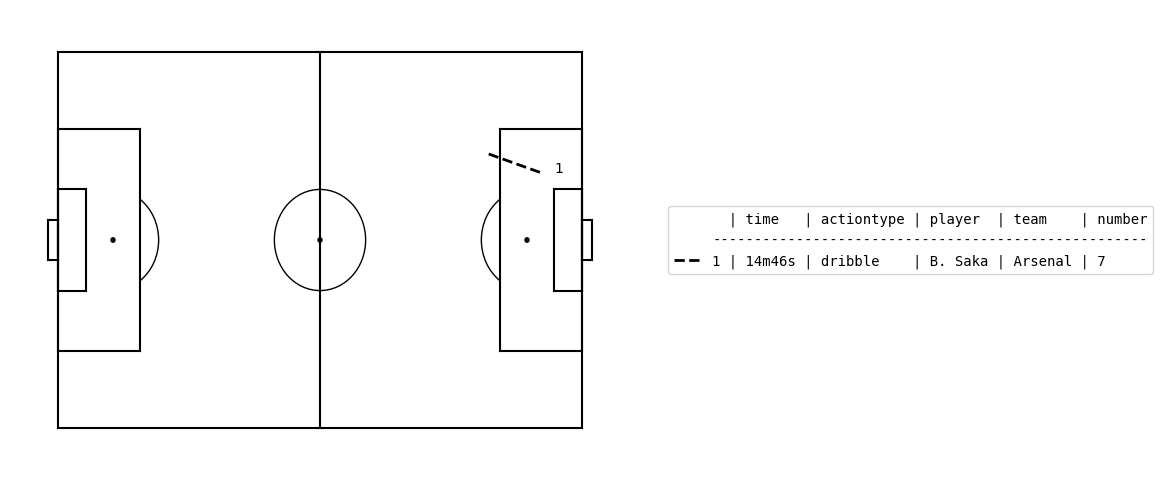

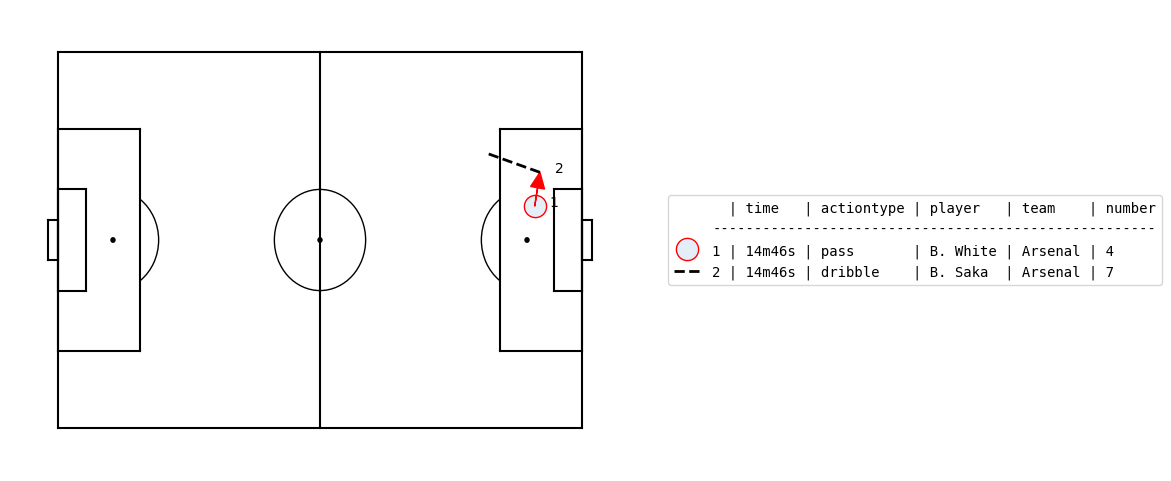

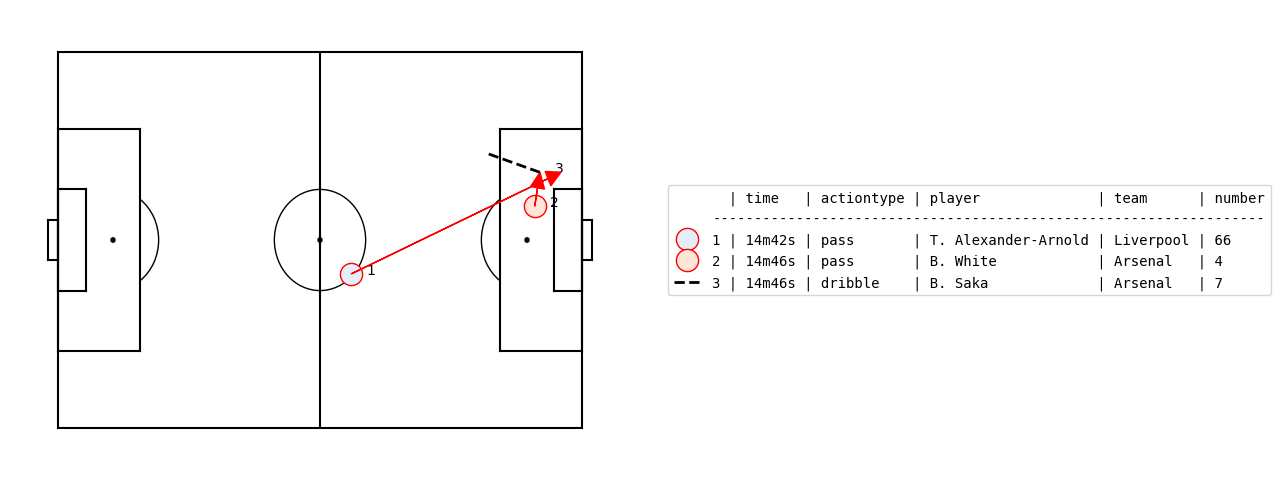

In [194]:
for i in range(3):
    df_actions_to_plot = df_actions[145-i:146]
    plot_actions(df_actions_to_plot)

In [195]:
delays = 3  # you can play around with this number
features_to_delay = ['game_id', 'period_id', 'time_seconds', 'team_id',
                     'player_id', 'start_x', 'start_y', 'end_x', 'end_y', 'bodypart_id',
                     'type_id', 'result_id', 'type_name', 'result_name', 'bodypart_name',
                     'time_played']

In [196]:
def create_delayed_features(df_actions, features_to_delay, delays):
    df_delays = [df_actions[features_to_delay].shift(step).add_suffix(f'-{step}') for step in range(0, delays)]
    return pd.concat(df_delays, axis=1)

In [197]:
df_features = create_delayed_features(df_actions, features_to_delay, delays)

In [198]:
location_cols = [f'{side}_{xy}-{delay}' for delay in reversed(range(0, delays))
                 for xy in ['x', 'y'] for side in ['start', 'end']]
df_features[action_id:action_id+1][location_cols]

,start_x-2,end_x-2,start_y-2,end_y-2,start_x-1,end_x-1,start_y-1,end_y-1,start_x-0,end_x-0,start_y-0,end_y-0
145,58.8,100.8,27.88,46.24,95.55,96.6,40.12,46.24,96.6,86.1,46.24,49.64


In [199]:
cols = [f'{col}-{delay}' for delay in reversed(range(0, delays))
        for col in ['period_id', 'time_seconds', 'type_name', 'bodypart_name', 'result_name']]
df_features[action_id:action_id+1][cols]

,period_id-2,time_seconds-2,type_name-2,bodypart_name-2,result_name-2,period_id-1,time_seconds-1,type_name-1,bodypart_name-1,result_name-1,period_id-0,time_seconds-0,type_name-0,bodypart_name-0,result_name-0
145,1.0,882.9,pass,foot,success,1.0,886.0,pass,foot,success,1,886.95,dribble,foot,success


We need to invert the coordinates for the actions made by the other team to make sure all features represent the same thing. Therefore we add an indicator for the delayed actions to indicate whether the action was executed by the same team or not. If not then we need to invert the coordinates as the coordinates normally always go from left to right for the team in possession.

In [200]:
def add_same_team(df_features, delays):
    for step in range(1, delays):
        df_features[f'team-{step}'] = df_features['team_id-0'] == df_features[f'team_id-{step}']

In [201]:
add_same_team(df_features, delays)

In [202]:
def invert_coordinates(df_features, delays):
    for step in range(1, delays):
        for side in ['start', 'end']:
            df_features.loc[~(df_features[f'team-{step}']), f'{side}_x-{step}'] = PITCH_LENGTH - df_features[f'{side}_x-{step}']
            df_features.loc[~(df_features[f'team-{step}']), f'{side}_y-{step}'] = PITCH_WIDTH - df_features[f'{side}_y-{step}']

In [203]:
df_features[location_cols+['team-1', 'team-2']].tail(10)

,start_x-2,end_x-2,start_y-2,end_y-2,start_x-1,end_x-1,start_y-1,end_y-1,start_x-0,end_x-0,start_y-0,end_y-0,team-1,team-2
1225,67.20,53.55,4.08,8.16,53.55,57.75,8.16,11.56,55.65,37.80,31.96,43.52,True,False
1226,53.55,57.75,8.16,11.56,55.65,37.80,31.96,43.52,57.75,55.65,11.56,31.96,True,True
1227,55.65,37.80,31.96,43.52,57.75,55.65,11.56,31.96,37.80,37.80,43.52,21.08,True,True
1228,57.75,55.65,11.56,31.96,37.80,37.80,43.52,21.08,37.80,55.65,21.08,10.20,True,True
1229,37.80,37.80,43.52,21.08,37.80,55.65,21.08,10.20,55.65,43.05,10.20,51.00,True,True
1230,37.80,55.65,21.08,10.20,55.65,43.05,10.20,51.00,43.05,60.90,51.00,55.76,True,True
1231,55.65,43.05,10.20,51.00,43.05,60.90,51.00,55.76,60.90,76.65,55.76,57.80,True,True
1232,43.05,60.90,51.00,55.76,60.90,76.65,55.76,57.80,76.65,82.95,57.80,62.56,True,True
1233,60.90,76.65,55.76,57.80,76.65,82.95,57.80,62.56,82.95,90.30,62.56,22.44,True,True
1234,76.65,82.95,57.80,62.56,82.95,90.30,62.56,22.44,90.30,102.90,22.44,25.16,False,False


In [204]:
invert_coordinates(df_features, delays)

In [205]:
df_features[location_cols+['team-1', 'team-2']].tail(10)

,start_x-2,end_x-2,start_y-2,end_y-2,start_x-1,end_x-1,start_y-1,end_y-1,start_x-0,end_x-0,start_y-0,end_y-0,team-1,team-2
1225,37.80,51.45,63.92,59.84,53.55,57.75,8.16,11.56,55.65,37.80,31.96,43.52,True,False
1226,53.55,57.75,8.16,11.56,55.65,37.80,31.96,43.52,57.75,55.65,11.56,31.96,True,True
1227,55.65,37.80,31.96,43.52,57.75,55.65,11.56,31.96,37.80,37.80,43.52,21.08,True,True
1228,57.75,55.65,11.56,31.96,37.80,37.80,43.52,21.08,37.80,55.65,21.08,10.20,True,True
1229,37.80,37.80,43.52,21.08,37.80,55.65,21.08,10.20,55.65,43.05,10.20,51.00,True,True
1230,37.80,55.65,21.08,10.20,55.65,43.05,10.20,51.00,43.05,60.90,51.00,55.76,True,True
1231,55.65,43.05,10.20,51.00,43.05,60.90,51.00,55.76,60.90,76.65,55.76,57.80,True,True
1232,43.05,60.90,51.00,55.76,60.90,76.65,55.76,57.80,76.65,82.95,57.80,62.56,True,True
1233,60.90,76.65,55.76,57.80,76.65,82.95,57.80,62.56,82.95,90.30,62.56,22.44,True,True
1234,28.35,22.05,10.20,5.44,22.05,14.70,5.44,45.56,90.30,102.90,22.44,25.16,False,False


In [206]:
def add_location_features(df_features, delays):
    for step in range(0, delays):
        for side in ['start', 'end']:
            # Normalize the X location
            key_x = f'{side}_x'
            df_features[f'{key_x}_norm-{step}'] = df_features[f'{key_x}-{step}'] / PITCH_LENGTH

            # Normalize the Y location
            key_y = f'{side}_y'
            df_features[f'{key_y}_norm-{step}'] = df_features[f'{key_y}-{step}'] / PITCH_WIDTH

            diff_x = GOAL_X - df_features[f'{side}_x-{step}']
            diff_y = abs(GOAL_Y - df_features[f'{side}_y-{step}'])
            df_features[f'{side}_distance_to_goal-{step}'] = np.sqrt(diff_x ** 2 + diff_y ** 2)
            df_features[f'{side}_angle_to_goal-{step}'] = np.divide(diff_x, diff_y, out=np.zeros_like(diff_x), where=(diff_y != 0))

            df_features[f'diff_x-{step}'] = df_features[f'end_x-{step}'] - df_features[f'start_x-{step}']
            df_features[f'diff_y-{step}'] = df_features[f'end_y-{step}'] - df_features[f'start_y-{step}']
            df_features[f'distance_covered-{step}'] = np.sqrt((df_features[f'end_x-{step}'] - df_features[f'start_x-{step}']) ** 2 +
                                             (df_features[f'end_y-{step}'] - df_features[f'start_y-{step}']) ** 2)

In [207]:
add_location_features(df_features, delays)

In [208]:
df_features.head()

,game_id-0,period_id-0,time_seconds-0,team_id-0,player_id-0,start_x-0,start_y-0,end_x-0,end_y-0,bodypart_id-0,...,start_y_norm-2,start_distance_to_goal-2,start_angle_to_goal-2,diff_x-2,diff_y-2,distance_covered-2,end_x_norm-2,end_y_norm-2,end_distance_to_goal-2,end_angle_to_goal-2
0,5465085,1,2.093,1609,340386,52.50,34.68,75.60,30.60,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5465085,1,5.114,1609,297621,75.60,30.60,37.80,2.72,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5465085,1,7.928,1609,425925,37.80,2.72,26.25,15.64,1,...,0.51,52.504404,77.205882,23.10,-4.08,23.457545,0.72,0.45,29.595946,8.647059
3,5465085,1,9.902,1612,393247,26.25,15.64,54.60,23.12,0,...,0.55,75.676416,22.235294,37.80,27.88,46.969505,0.64,0.96,49.064023,1.208440
4,5465085,1,12.330,1609,578325,54.60,23.12,36.75,14.96,1,...,0.04,74.123400,2.148338,-11.55,12.92,17.330000,0.25,0.23,80.861932,4.289216


## Adding contextual features
We also want to add some additional context to the game state. For example the speed of play, the time in the match and the current score in the match might influence the value of the game state.

Exercise: think of extra features that might influence the value of a game state.

## Sequence features
The following cells add extra context on the sequence. The distance covered in x and y direction as well as the time passed in the sequence are added to the dataframe. These features might tell the model something about the speed of play, whether the game quickly progressed from one side to another (probably indicating a counter attack) or whether it is a slow build up play.

In [209]:
def add_sequence_pre_features(df_features, delays):
    delay = delays - 1
    df_features['xdiff_sequence_pre'] = df_features['start_x-0'] - df_features[f'start_x-{delay}']
    df_features['ydiff_sequence_pre'] = df_features['start_y-0'] - df_features[f'start_y-{delay}']
    df_features['time_sequence_pre'] = df_features['time_played-0'] - df_features[f'time_played-{delay}']

In [210]:
add_sequence_pre_features(df_features, delays)

In [211]:
def add_sequence_post_features(df_features, delays):
    delay = delays - 1
    df_features['xdiff_sequence_post'] = df_features['end_x-0'] - df_features[f'start_x-{delay}']
    df_features['ydiff_sequence_post'] = df_features['end_y-0'] - df_features[f'start_y-{delay}']

In [212]:
add_sequence_post_features(df_features, delays)

In [213]:
df_features[action_id:action_id+1]

,game_id-0,period_id-0,time_seconds-0,team_id-0,player_id-0,start_x-0,start_y-0,end_x-0,end_y-0,bodypart_id-0,...,distance_covered-2,end_x_norm-2,end_y_norm-2,end_distance_to_goal-2,end_angle_to_goal-2,xdiff_sequence_pre,ydiff_sequence_pre,time_sequence_pre,xdiff_sequence_post,ydiff_sequence_post
145,5465085,1,886.95,1609,520291,96.6,46.24,86.1,49.64,0,...,45.837644,0.04,0.32,101.540423,8.235294,50.4,6.12,4.05,39.9,9.52


## Generate features for a match
The following cell defines a function that creates all features described above for a dataframe of actions for a given match.

In [ ]:
def create_features_match(df_actions, features_to_delay, delays):
    df_action_features = add_action_type_dummies(df_actions)
    add_time_played(df_action_features)
    df_gamestate_features = create_delayed_features(df_action_features, features_to_delay, delays)
    add_same_team(df_gamestate_features, delays)
    invert_coordinates(df_gamestate_features, delays)
    add_location_features(df_gamestate_features, delays)
    add_sequence_pre_features(df_gamestate_features, delays)
    add_sequence_post_features(df_gamestate_features, delays)
    return df_gamestate_features

## Generate labels for a match
The following cells define two functions that compute the labels of our two machine learning tasks. The first one tells us whether a goal was scored within x actions, whereas the second function tells us whether a goal was conceded within the next x actions.

Exercise: play around with the number of actions to look ahead. In our paper we look 10 actions ahead.

In [214]:
def label_scores(df_actions, nr_actions):
    """
    This functiondf_actions determines whether a goal was scored by the team possessing 
    the ball within the next x actions
    """
    # merging goals, owngoals and team_ids

    goals = df_actions['type_name'].str.contains('shot') & (
        df_actions['result_id'] == 1
    )
    owngoals = df_actions['type_name'].str.contains('shot') & (
        df_actions['result_id'] == 2
    )
    y = pd.concat([goals, owngoals, df_actions['team_id']], axis=1)
    y.columns = ['goal', 'owngoal', 'team_id']

    # adding future results
    for i in range(1, nr_actions):
        for col in ['team_id', 'goal', 'owngoal']:
            shifted = y[col].shift(-i)
            shifted[-i:] = y[col][len(y) - 1]
            y[f'{col}+{i}'] = shifted

    scores = y['goal']
    for i in range(1, nr_actions):
        goal_scored = y[f'goal+{i}'] & (y[f'team_id+{i}'] == y['team_id'])
        own_goal_opponent = y[f'owngoal+{i}'] & (y[f'team_id+{i}'] != y['team_id'])
        scores = scores | goal_scored | own_goal_opponent

    return pd.DataFrame(scores, columns=['scores'])

In [215]:
def label_concedes(df_actions, nr_actions):
    """
    This function determines whether a goal was scored by the team not 
    possessing the ball within the next x actions
    """
    # merging goals,owngoals and team_ids
    goals = df_actions['type_name'].str.contains('shot') & (
        df_actions['result_id'] == 1
    )
    owngoals = df_actions['type_name'].str.contains('shot') & (
        df_actions['result_id'] == 2
    )
    y = pd.concat([goals, owngoals, df_actions['team_id']], axis=1)
    y.columns = ['goal', 'owngoal', 'team_id']
    
    # adding future results
    for i in range(1, nr_actions):
        for col in ['team_id', 'goal', 'owngoal']:
            shifted = y[col].shift(-i)
            shifted[-i:] = y[col][len(y) - 1]
            y[f'{col}+{i}'] = shifted

    concedes = y['owngoal']
    for i in range(1, nr_actions):
        goal_opponent = y[f'goal+{i}'] & (y[f'team_id+{i}'] != y['team_id'])
        own_goal_team = y[f'owngoal+{i}'] & (y[f'team_id+{i}'] == y['team_id'])
        concedes = concedes | goal_opponent | own_goal_team

    return pd.DataFrame(concedes, columns=['concedes'])

We compute the labels for the match and investigate the labels for the last ten actions in the match.

In [216]:
df_labels = pd.concat([label_scores(df_actions, nr_actions=10), 
                           label_concedes(df_actions, nr_actions=10)], 
                          axis=1)

In [217]:
df_labels.tail(10)

,scores,concedes
1225,False,False
1226,False,False
1227,False,False
1228,False,False
1229,False,False
1230,False,False
1231,False,False
1232,False,False
1233,False,False
1234,False,False


In [222]:
clean_format = pd.merge(df_actions[['team_name', 'nickname', 'type_name']], 
         df_labels, 
         left_index=True, 
         right_index=True)

In [224]:
clean_format[clean_format['scores'] == 1]

,team_name,nickname,type_name,scores,concedes
37,Arsenal FC,Gabriel Magalhaes,pass,True,False
39,Arsenal FC,M. Ødegaard,freekick_crossed,True,False
40,Arsenal FC,Gabriel Magalhaes,dribble,True,False
41,Arsenal FC,Gabriel Magalhaes,shot,True,False
375,Liverpool FC,T. Alexander-Arnold,interception,True,False
376,Liverpool FC,T. Alexander-Arnold,pass,True,False
377,Liverpool FC,C. Jones,pass,True,False
378,Liverpool FC,V. van Dijk,pass,True,False
379,Liverpool FC,T. Alexander-Arnold,pass,True,False
380,Liverpool FC,V. van Dijk,pass,True,False


## Generate features and labels for all matches
The following cells generate and store the features and labels for all matches in your spadl.h5 file. This might take some minutes.

This works if you have all games stored in the data folder. If you only have a subset of the games, you can use the following code to only generate the features and labels for the games you have.

In [ ]:
df_games = pd.read_hdf('spadl.h5', key='games')

In [ ]:
df_games.head()

In [ ]:
for _, game in tqdm(df_games.iterrows(), total=len(df_games)):
    game_id = game['game_id']
    with pd.HDFStore('spadl.h5') as spadlstore:
        df_actions = spadlstore[f'actions/game_{game_id}']
        df_actions = (
            df_actions.merge(spadlstore['actiontypes'], how='left')
            .merge(spadlstore['results'], how='left')
            .merge(spadlstore['bodyparts'], how='left')
            .reset_index(drop=True)
        )
    
    df_features = create_features_match(df_actions, features_to_delay, delays)
    df_features.to_hdf('features.h5', f'game_{game_id}')
    
    df_labels = pd.concat([label_scores(df_actions, nr_actions=10), 
                           label_concedes(df_actions, nr_actions=10)], 
                          axis=1)
    df_labels.to_hdf('labels.h5', f'game_{game_id}')